# Shor's factorization algorithm with hierarcqal


In [13]:
#!pip install qiskit-aer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hierarqcal import (
    Qinit,
    Qmask,
    Qunmask,
    Qunitary,
    Qpivot,
    Qcycle,
)

## Helper functions

In [3]:
from qiskit import Aer, execute

def experiment(circuit, shots=50000, seed=None):
    """
    Run the circuit on a simulator and return figure and counts
    """
    backend = Aer.get_backend("qasm_simulator")
    job = execute(circuit, backend, shots=shots, seed_simulator=seed)
    result = job.result()
    counts = result.get_counts()

    probs = [counts[c] / shots for c in counts.keys()]
    counts = dict(zip(counts.keys(), probs))

    n = len(list(counts.keys())[0])

    ## Create fig to show counts
    fig = plt.figure()

    # Plot red dash line to show uniform distribution (currently hidden, alpha = 0)
    plt.plot(
        [bin(i)[2:].zfill(n) for i in range(2**n)],
        [1 / 2 ** (n) for i in range(2**n)],
        "--r",
        alpha=0,
    )

    plt.bar(counts.keys(), counts.values())

    plt.xlabel("State")
    plt.ylabel("Quasi-probability")
    plt.xticks(rotation=90)

    return fig, counts


def get_fft(counts, n):
    """
    Compute the fast Fourier transform of the counts and return the normalized probability distribution.
    """
    X = [
        counts[bin(k)[2:].zfill(n)[::-1]]
        if bin(k)[2:].zfill(n)[::-1] in counts.keys()
        else 0
        for k in range(2**n)
    ]
    Y = []
    for k in range(len(X)):
        Y.append(
            np.sum(
                [X[n] * np.exp(2 * np.pi * 1j * k * n / len(X)) for n in range(len(X))]
            )
        )

    Y = [abs(x) ** 2 for x in Y]
    Y = Y / sum(Y)
    return Y


## Background

$$f(x) = \prod_{i=1}^{2L-1} m^{2^i k_i} \mod N$$

## Binary reformulation


## Choose the number to factorize

In [7]:
N  = 4
# binary string that represents N
N_binary = bin(N)[2:]
L = len(N_binary)
n = 2*L+4

In [10]:
N, L, n

(4, 3, 10)

In [15]:
U = Qmask("0"*2*L+"!") + Qcycle(mapping=Qunitary("h()^0")) + Qunmask("previous")
circuit = Qinit(n) + U

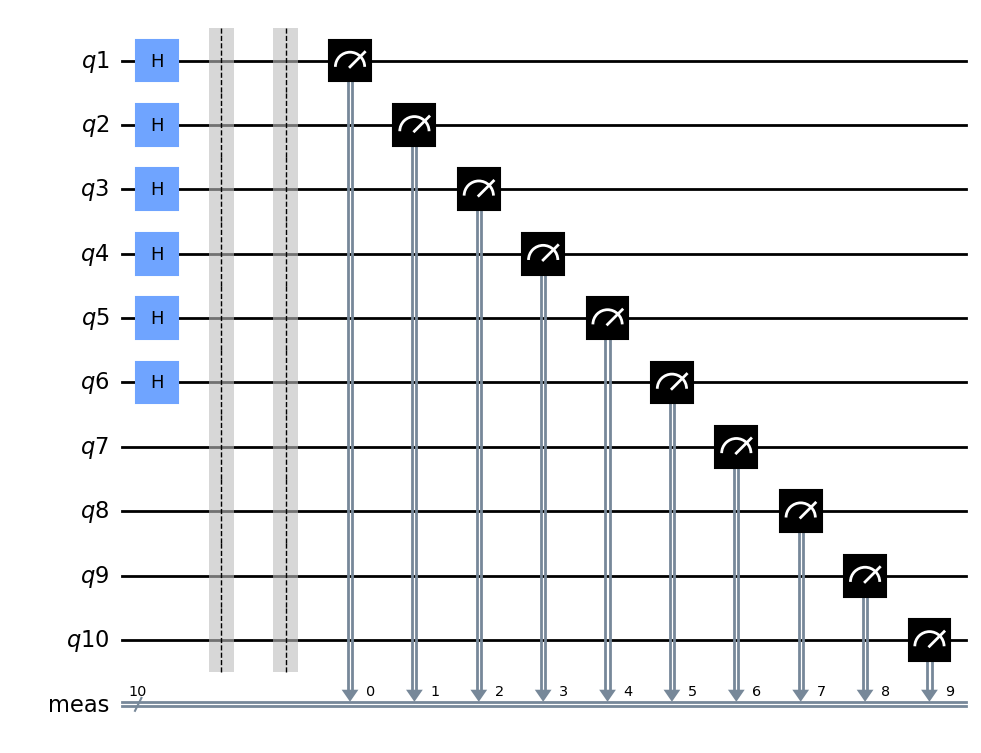

In [16]:
circuit_qft = circuit(backend="qiskit")
circuit_qft.measure_all()
circuit_qft.draw("mpl")

## QFT on $n$ qubits in just a few lines!

In [17]:
# QFT circuit
qft = (
    Qpivot(mapping=Qunitary("h()^0"))
    + Qpivot(
        mapping=Qunitary("cp(x)^01"),
        share_weights=False,
        symbol_fn=lambda x, ns, ne: np.pi * 2 ** (-ne),
    )
    + Qmask("1*")
) * n

# Initialize n qubits and append the QFT circuit
qft_n = Qinit(n) + qft


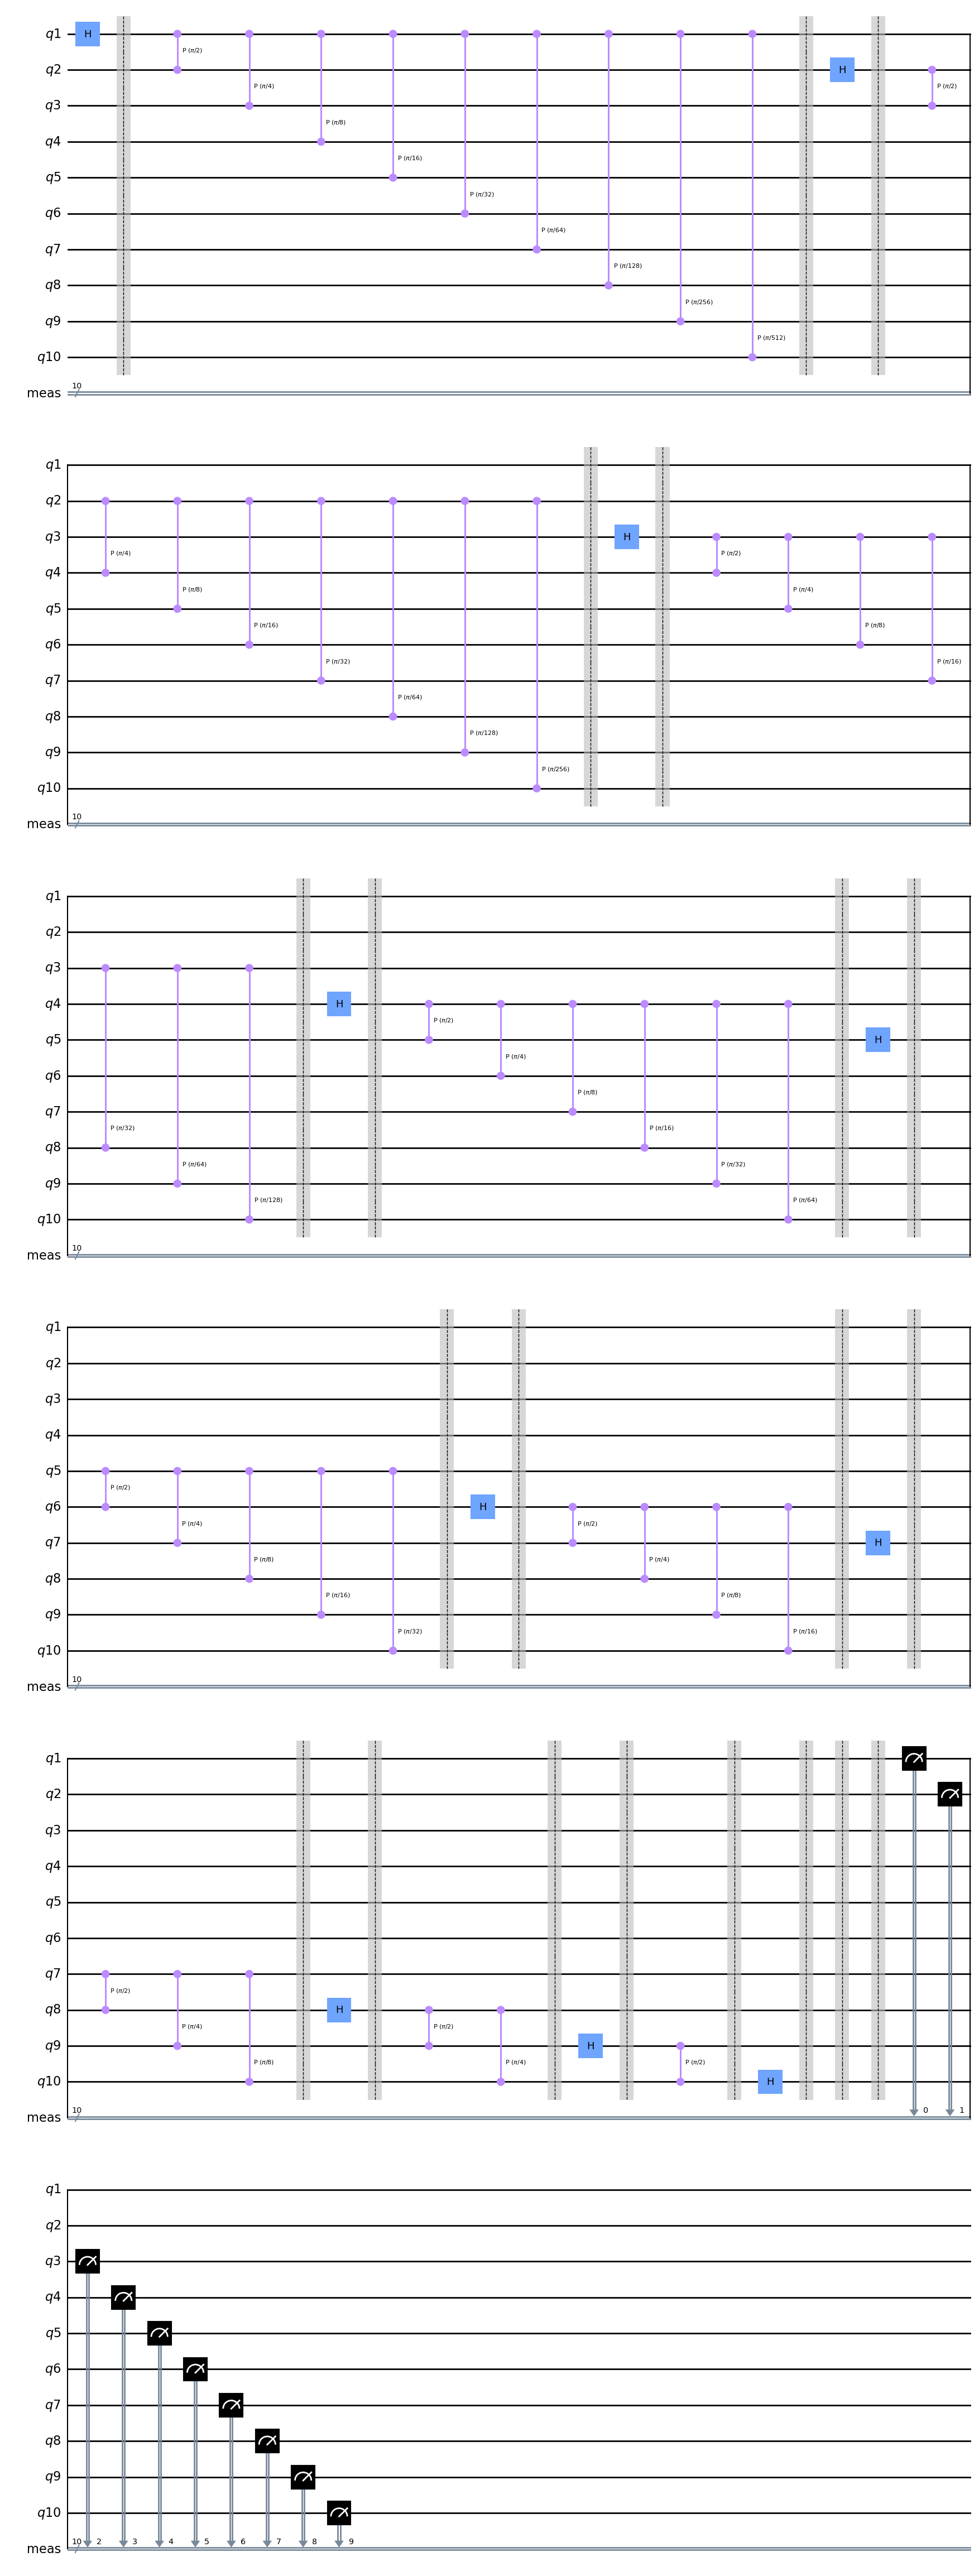

In [18]:
circuit_qft = qft_n(backend="qiskit")
circuit_qft.measure_all()
circuit_qft.draw("mpl")